In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
%pip install mlxtend --upgrade
from mlxtend.evaluate import bias_variance_decomp
import matplotlib.pyplot as plt
import seaborn as sns

     |████████████████████████████████| 1.3 MB 5.2 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


# Data cleaning

In [3]:
df = pd.read_csv('clean_kaggle_data_2021.csv')
df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,284,285,286,287,288,289,290,291,292) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER,Q25_Encoded,Q25_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,...,"In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...",NaN,NaN
1,910,50-54,Man,India,Bachelor’s degree,Other,5-10 years,Python,R,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,"20,000-29,999"
2,784,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,NaN,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,6.0,"60,000-69,999"
3,924,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,Python,NaN,NaN,...,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"0-9,999"
4,575,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,3.0,"30,000-39,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15387,323,30-34,Man,India,Bachelor’s degree,Data Analyst,1-3 years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"0-9,999"
15388,910,35-39,Man,South Korea,Bachelor’s degree,Software Engineer,5-10 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,"80,000-89,999"
15389,1756,30-34,Man,Egypt,Bachelor’s degree,Data Analyst,1-3 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,"10,000-19,999"
15390,494,50-54,Man,Sweden,Doctoral degree,Research Scientist,I have never written code,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,"0-9,999"


In [4]:
#Find out the questions which are multiple choices in the df
col_name = df.columns.tolist()
q_1label_lst = []
for i in col_name:
  name_split = i.split('_')
  if ('Part' or 'OTHER') in name_split:
    q_1label = name_split[0].split('Q')[1]
    q_1label = int(q_1label)
    q_1label_lst.append(q_1label)

q_1label_lst = list(set(q_1label_lst))

q_2labels_lst = []
for i in col_name:
  if ('_A_Part' or '_A_OTHER') in i:
    name_split = i.split('_')
    q_2labels = name_split[0].split('Q')[1]
    q_2labels = int(q_2labels)
    q_2labels_lst.append(q_2labels)

q_2labels_lst = list(set(q_2labels_lst))

for i in q_2labels_lst:
  q_1label_lst.remove(i)

q_1label_lst.sort()
q_2labels_lst.sort()

print(q_1label_lst,"\n", q_2labels_lst)

[7, 9, 10, 12, 14, 16, 17, 18, 19, 24, 39, 40, 42] 
 [27, 29, 30, 31, 32, 34, 36, 37, 38]


In [5]:
#Combine the questions that have multiple choices
#Sum up the number of choices a attendee has select in each question
def combined_multi_choices(combined_df, q_label_lst, string_1, string_2, string_3=""):
  for num in q_label_lst:
    sum_col = 0

    for col in col_name:
      if (('Q'+str(num)+ string_1) in col) or (('Q'+str(num)+ string_2) in col):
        combined_df[col][combined_df[col].notna()] = 1
        combined_df[col] = combined_df[col].fillna(0)
        sum_col += combined_df[col]
        combined_df.drop(columns=col, inplace=True)


    combined_df['Q{}{}'.format(num,string_3)] = sum_col
  




In [6]:
combined_df = df.copy()
combined_df = combined_df.drop(0)

combined_multi_choices(combined_df, q_1label_lst, '_Part', '_OTHER')
combined_multi_choices(combined_df, q_2labels_lst, '_A_Part', '_A_OTHER', '_A')
combined_multi_choices(combined_df, q_2labels_lst, '_B_Part', '_B_OTHER', '_B')

combined_df.drop(columns='Time from Start to Finish (seconds)',inplace = True ) 
combined_df


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Q1,Q2,Q3,Q4,Q5,Q6,Q8,Q11,Q13,Q15,...,Q38_A,Q27_B,Q29_B,Q30_B,Q31_B,Q32_B,Q34_B,Q36_B,Q37_B,Q38_B
1,50-54,Man,India,Bachelor’s degree,Other,5-10 years,Python,A laptop,2-5 times,5-10 years,...,1,0,0,0,0,0,0,0,0,0
2,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,Python,"A cloud computing platform (AWS, Azure, GCP, h...",Never,Under 1 year,...,0,2,1,0,1,4,2,1,1,1
3,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,Python,A laptop,Never,I do not use machine learning methods,...,1,2,2,0,3,3,2,1,1,1
4,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,Python,"A cloud computing platform (AWS, Azure, GCP, h...",More than 25 times,5-10 years,...,0,2,2,0,1,1,1,1,0,1
5,45-49,Man,India,Doctoral degree,Other,< 1 years,Python,"A cloud computing platform (AWS, Azure, GCP, h...",Never,10-20 years,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15387,30-34,Man,India,Bachelor’s degree,Data Analyst,1-3 years,Python,"A cloud computing platform (AWS, Azure, GCP, h...",Once,1-2 years,...,0,0,0,0,0,0,0,0,0,0
15388,35-39,Man,South Korea,Bachelor’s degree,Software Engineer,5-10 years,Python,A personal computer / desktop,2-5 times,3-4 years,...,1,0,0,0,0,0,0,0,0,0
15389,30-34,Man,Egypt,Bachelor’s degree,Data Analyst,1-3 years,Python,A laptop,Never,1-2 years,...,1,0,0,0,0,0,0,0,0,0
15390,50-54,Man,Sweden,Doctoral degree,Research Scientist,I have never written code,NaN,NaN,NaN,NaN,...,0,3,3,0,8,19,2,1,0,1


In [7]:
#Drop the coloumn that has over 2/3 values to be null
combined_col_name = combined_df.columns.tolist()  

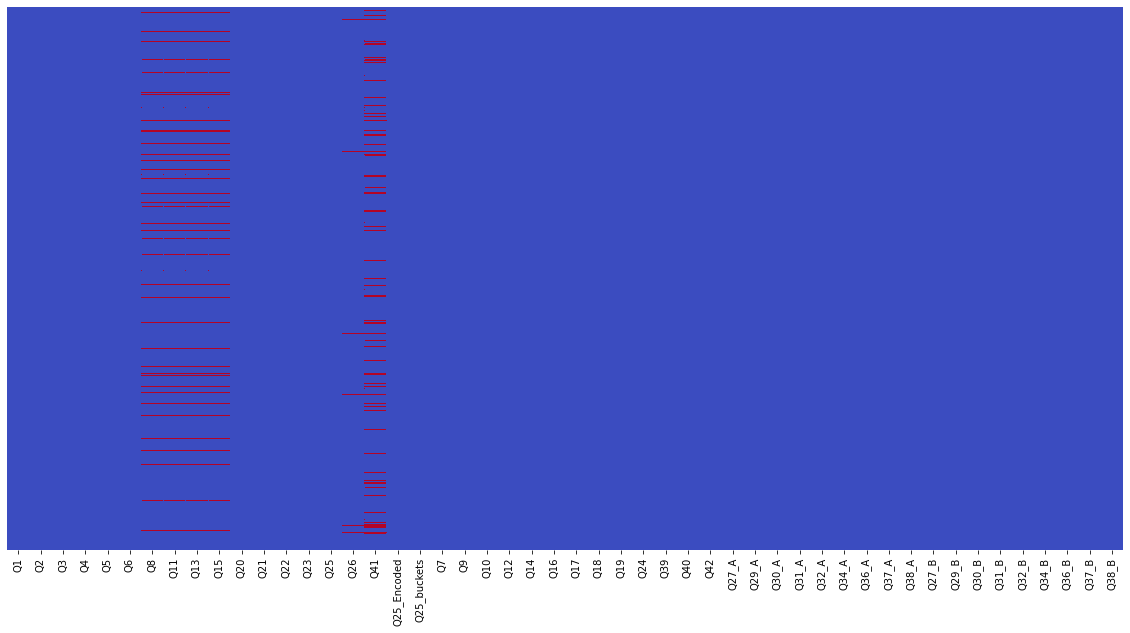

In [8]:
for col in combined_col_name:
  na_percent = combined_df[col].isna().sum() / combined_df.shape[0]
  if na_percent >= 2/3:
    combined_df.drop(columns=col, inplace=True)

fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(combined_df.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)

In [9]:
# Find out which few columns has null values
combined_col_name = combined_df.columns.tolist()  

In [10]:
null_column = []
for col in combined_col_name:
  if combined_df[col].isnull().values.any():
    null_column.append(col)

null_column

['Q8', 'Q11', 'Q13', 'Q15', 'Q26', 'Q41']

In [11]:
#Since Q41 is about what editor you use to code, it is not influential to the income.
#We drop the Q41

combined_df.drop(columns='Q41', inplace=True)

In [12]:
null_column.remove('Q41')

In [13]:
# All the rest of columns in null_column are categorical column
# Relace the null values with the column's most common value, if the number of null values is less than 10% of the column
count = 0

for col in null_column:
  na_percent = combined_df[col].isna().sum() / combined_df.shape[0]
  if na_percent <= 0.1:
    count += 1

if count == len(null_column):
  print("All columns that have null values, can use the most common value to replace the null value")

All columns that have null values, can use the most common value to replace the null value


In [14]:
for col in null_column:
  most_comm = combined_df[col].value_counts().index[0]
  combined_df.at[combined_df[col].isnull(), col] = most_comm


In [15]:
combined_df.isnull().values.any()

False

In [16]:
combined_df.drop(columns=['Q25','Q25_buckets'], inplace = True)

In [17]:
# Since there are no more null values, we can encode these categorical columns
clean_df = combined_df.copy()

col_name = clean_df.columns.tolist()
stop_index = col_name.index('Q26')

convert_col_name = []
for i in range(stop_index+1):
  convert_col_name.append(col_name[i])


In [18]:
convert_col_name

['Q1',
 'Q2',
 'Q3',
 'Q4',
 'Q5',
 'Q6',
 'Q8',
 'Q11',
 'Q13',
 'Q15',
 'Q20',
 'Q21',
 'Q22',
 'Q23',
 'Q26']

In [19]:
# Create dummy features for each categorical feature
for col in convert_col_name:
  dummies = pd.get_dummies(clean_df[col], prefix=col)

  # Add the new features to the dataframe via concating
  clean_df = pd.concat([clean_df, dummies], axis=1)

  last_categ = clean_df[col].value_counts().index[-1]

  # Drop the original categorical feature columns
  clean_df.drop(columns=col, inplace=True)

  # Drop one of each of the dummy variables because its value is implied
  # by the other dummy variable columns
  clean_df.drop('{}_{}'.format(col,last_categ), axis=1, inplace=True)



In [20]:
clean_df

,Q25_Encoded,Q7,Q9,Q10,Q12,Q14,Q16,Q17,Q18,Q19,...,Q23_I do not know,Q23_No (we do not use ML methods),Q23_We are exploring ML methods (and may one day put a model into production),"Q23_We have well established ML methods (i.e., models in production for more than 2 years)","Q23_We recently started using ML methods (i.e., models in production for less than 2 years)",Q26_$0 ($USD),Q26_$1-$99,"Q26_$10,000-$99,999",Q26_$100-$999,"Q26_$1000-$9,999"
1,2.0,2,1,1,1,5,3,7,1,1,...,0,1,0,0,0,0,0,0,1,0
2,6.0,4,2,2,1,1,1,2,0,0,...,0,0,1,0,0,1,0,0,0,0
3,0.0,3,3,1,1,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,3.0,1,2,1,1,1,3,3,4,1,...,1,0,0,0,0,1,0,0,0,0
5,3.0,3,3,1,1,3,3,5,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15387,0.0,2,2,1,2,3,5,5,5,0,...,0,0,0,1,0,0,0,0,1,0
15388,8.0,3,2,2,1,2,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
15389,1.0,4,4,4,1,2,6,4,3,0,...,0,0,1,0,0,0,0,0,0,1
15390,0.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


#Exploratory data analysis and feature selection

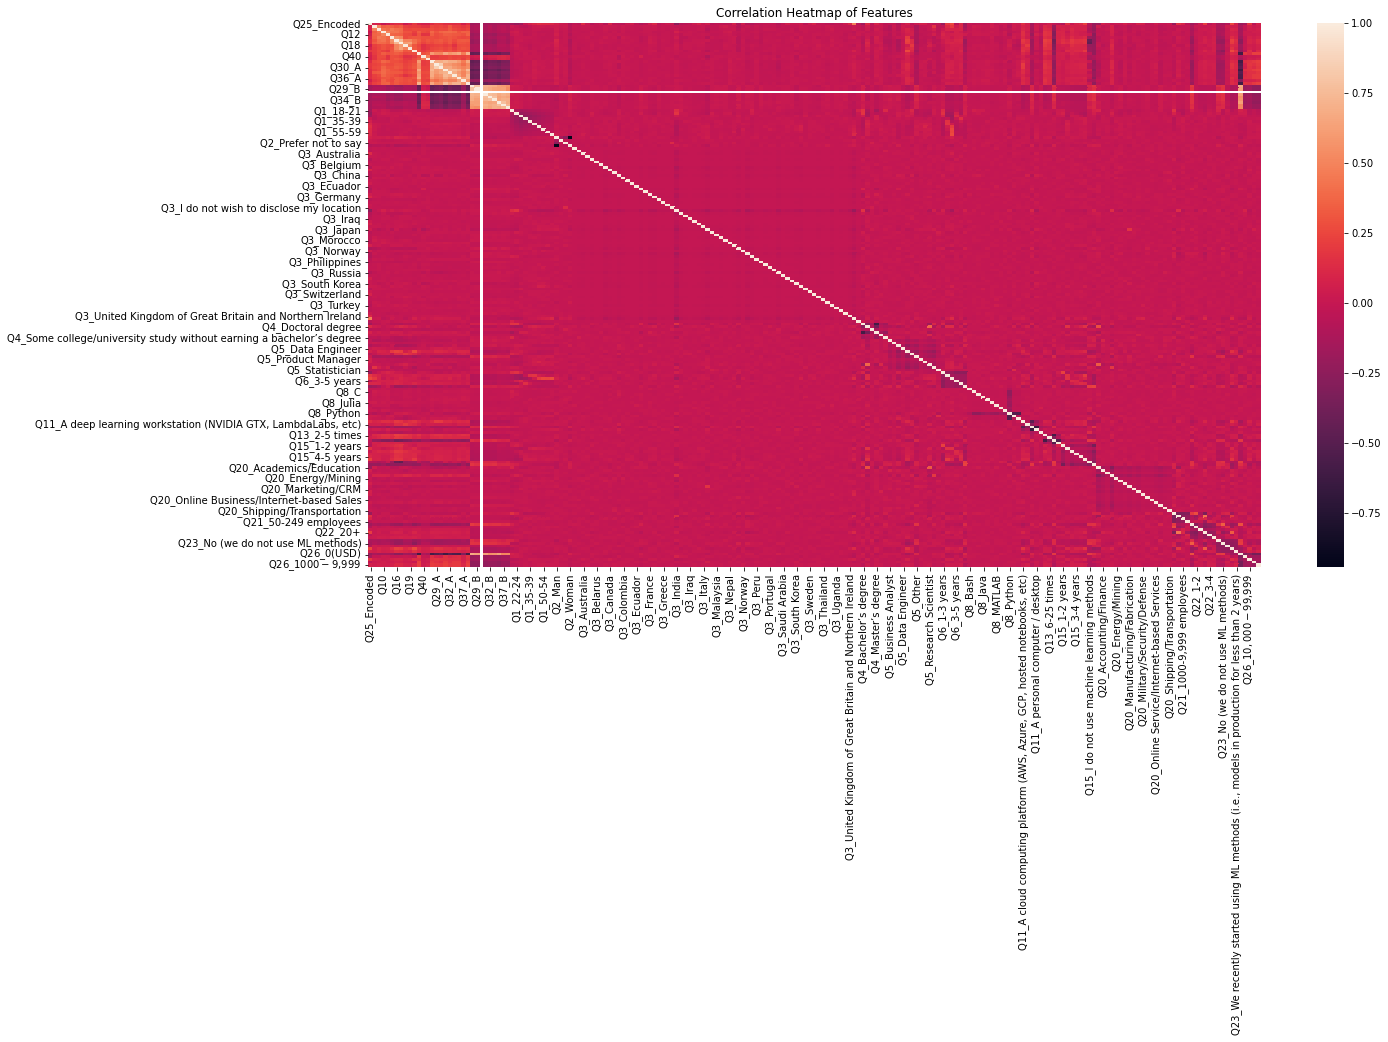

In [21]:
#correlation heatmap
corr = clean_df.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr)
plt.title('Correlation Heatmap of Features')
plt.show()

In [22]:
#Finding the features that are related to yearly compensation with correlation bigger than 0.05
q25_corr = corr[['Q25_Encoded']]
q25_corr = q25_corr.abs()

q25_corr = q25_corr.sort_values(by=['Q25_Encoded'], ascending=False)

q25_corr = q25_corr[q25_corr['Q25_Encoded'] >= 0.05]
q25_corr[:6]

,Q25_Encoded
Q25_Encoded,1.000000
Q3_United States of America,0.482180
Q6_20+ years,0.263827
"Q23_We have well established ML methods (i.e., models in production for more than 2 years)",0.256236
Q3_India,0.246152
Q15_5-10 years,0.231519


In [23]:
q25_corr.shape

(107, 1)

In [24]:
col_name = q25_corr.index.tolist()
features = col_name.copy()
features.remove('Q25_Encoded')
clean_df = clean_df[col_name]

In [25]:
# Use to lasso regression to eliminate more features
X = clean_df.drop(['Q25_Encoded'],axis=1)
y = clean_df['Q25_Encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

search.fit(X_train,y_train)
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)


Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END .................model__alpha=0.1;, score=-7.472 total time=   0.1s
[CV 2/5] END .................model__alpha=0.1;, score=-7.000 total time=   0.2s
[CV 3/5] END .................model__alpha=0.1;, score=-7.950 total time=   0.2s
[CV 4/5] END .................model__alpha=0.1;, score=-7.339 total time=   0.2s
[CV 5/5] END .................model__alpha=0.1;, score=-7.758 total time=   0.1s
[CV 1/5] END .................model__alpha=0.2;, score=-8.247 total time=   0.1s
[CV 2/5] END .................model__alpha=0.2;, score=-7.642 total time=   0.2s
[CV 3/5] END .................model__alpha=0.2;, score=-8.768 total time=   0.1s
[CV 4/5] END .................model__alpha=0.2;, score=-8.074 total time=   0.2s
[CV 5/5] END .................model__alpha=0.2;, score=-8.452 total time=   0.2s
[CV 1/5] END .model__alpha=0.30000000000000004;, score=-9.142 total time=   0.2s
[CV 2/5] END .model__alpha=0.30000000000000004;

In [26]:
np.array(features)[importance > 0].shape

(65,)

In [27]:
#Since there are too many features are non-zero, we choose 10 with the biggest absolute coefficients 
sort_index = np.argsort(importance)
final_features = []

for i in range(-10,0):
  one_fea = features[sort_index[i]]
  final_features.append(one_fea)

final_features.append('Q25_Encoded')

In [28]:
final_df = clean_df[final_features]

#Model implementation

In [29]:
X = final_df.drop(['Q25_Encoded'],axis=1)
y = final_df['Q25_Encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [30]:
#Since the features we select are all binary variables, there is no need for standardization
final_df.columns

Index(['Q1_25-29', 'Q20_Academics/Education', 'Q6_10-20 years', 'Q3_India',
       'Q1_22-24', 'Q3_United Kingdom of Great Britain and Northern Ireland',
       'Q6_20+ years', 'Q3_Australia', 'Q3_Germany',
       'Q3_United States of America', 'Q25_Encoded'],
      dtype='object')

In [31]:
import warnings
#warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

model = LogisticRegression()    
model.fit(X_train, y_train)

model = LogisticRegression()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)

accuracy = np.zeros(10)
np_idx = 0

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    TN = confusion_matrix(y_test, predictions)[0][0]
    FP = confusion_matrix(y_test, predictions)[0][1]
    FN = confusion_matrix(y_test, predictions)[1][0]
    TP = confusion_matrix(y_test, predictions)[1][1]
    total = TN + FP + FN + TP
    ACC = (TP + TN) / float(total)
    
    accuracy[np_idx] = ACC*100
    np_idx += 1
    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC*100,3)))   

print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.var(accuracy),3)))

Fold 1: Accuracy: 81.797%
Fold 2: Accuracy: 81.981%
Fold 3: Accuracy: 80.702%
Fold 4: Accuracy: 82.551%
Fold 5: Accuracy: 82.424%
Fold 6: Accuracy: 85.167%
Fold 7: Accuracy: 80.958%
Fold 8: Accuracy: 81.051%
Fold 9: Accuracy: 81.34%
Fold 10: Accuracy: 82.105%
Average Score: 82.008%(1.467%)


In [34]:
# Here, we try different values for c, which shows the inverse of regularization strength
c = [0.001,0.01,0.05,0.1,0.5,1,5,10, 100]
mse_lst = []
bias_lst = []
var_lst = []

for i in range(len(c)):
    model= LogisticRegression(C=c[i])
    model.fit(X_train, y_train)
    accuracy = round(model.score(X_test, y_test),3)
    mse, bias, var = bias_variance_decomp(model, X_train, y_train, X_test, y_test, loss='mse', random_seed=1)
    mse_lst.append(mse)
    bias_lst.append(bias)
    var_lst.append(var)
    print("Model",i+1,"Score:",accuracy*100)


Model 1 Score: 46.7
Model 2 Score: 47.199999999999996
Model 3 Score: 47.8
Model 4 Score: 47.599999999999994
Model 5 Score: 48.1
Model 6 Score: 48.1
Model 7 Score: 48.1
Model 8 Score: 48.1
Model 9 Score: 48.1


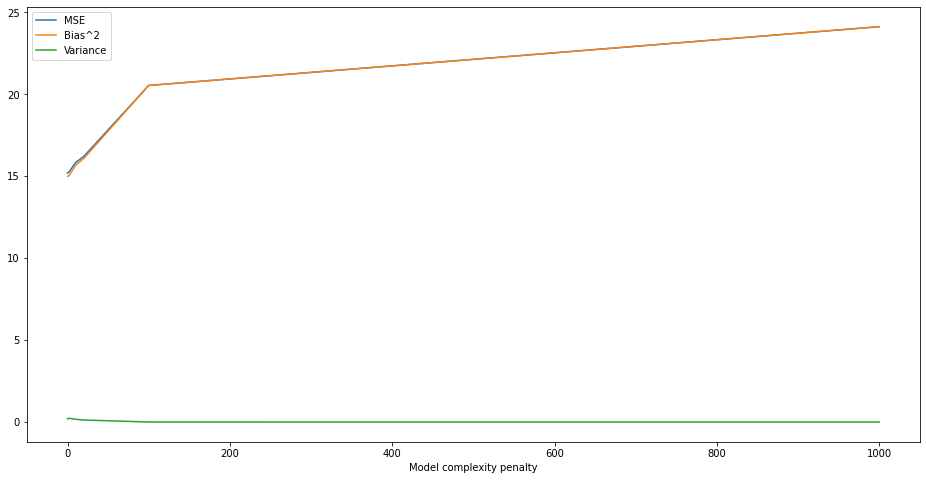

In [41]:
out = pd.DataFrame(columns = ['C', 'MSE', 'Bias^2', 'Variance'])
out['C'] = c
out['Model complexity penalty'] = 1/out['C']
out['MSE'] = mse_lst
out['Bias^2'] = bias_lst
out['Variance'] = var_lst

out.plot(x='Model complexity penalty', y=['MSE', 'Bias^2', 'Variance'], figsize=(16,8))
plt.show()  

#Model tuning

In [31]:
#There are 3 hyperparameters that can be used to tune in logistic regression
#solver in [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’]
#penalty in [‘none’, ‘l1’, ‘l2’, ‘elasticnet’]
#The C parameter controls the penality strength, which can also be effective.
#C in [0.001,0.01,0.05,0.1,0.5,1,5,10, 100]

# We choose C and solver to tune in this part.

model = LogisticRegression()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0

for C in [0.001,0.01,0.05,0.1,0.5,1,5,10, 100]:
    for solver in ['newton-cg','lbfgs','liblinear','sag']:
        
        model = LogisticRegression(C=C, solver=solver)
        accuracy = np.zeros(10)
        np_idx = 0
        
        for train_idx, test_idx in kfold.split(X):
            X_train, X_test = X.values[train_idx], X.values[test_idx]
            y_train, y_test = y.values[train_idx], y.values[test_idx]

            model.fit(X_train, y_train)

            predictions = model.predict(X_test)

            TN = confusion_matrix(y_test, predictions)[0][0]
            FP = confusion_matrix(y_test, predictions)[0][1]
            FN = confusion_matrix(y_test, predictions)[1][0]
            TP = confusion_matrix(y_test, predictions)[1][1]
            total = TN + FP + FN + TP
            ACC = (TP + TN) / float(total)

            accuracy[np_idx] = ACC*100
            np_idx += 1
        
        if np.mean(accuracy) > best_accuracy:
            best_model = model
            best_params = {'C':C, 'solver':solver}
            best_accuracy = np.mean(accuracy)
            best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_std,3)))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


{'C': 0.001, 'solver': 'newton-cg'}
Best Score: 82.139%(1.317%)

The optimal log model uses C=0.001, and a newton-cg solver, and has a cross validation score of 82.139% with a standard deviation of 1.317%


In [33]:
# Use slope coefficients as features importance 
model = LogisticRegression(C=0.001, solver='newton-cg')
model.fit(X_train, y_train)
importance = model.coef_[0]

In [46]:
col_name = X.columns.tolist()
coeff_df = pd.DataFrame(importance, columns=['Coefficient'], index=np.array(col_name))
coeff_df = coeff_df.abs()
coeff_df = coeff_df.sort_values(by=['Coefficient'], ascending=False)

coeff_df

,Coefficient
Q3_United States of America,0.392790
Q1_22-24,0.334078
Q20_Academics/Education,0.298670
Q3_India,0.289850
Q6_10-20 years,0.276105
Q6_20+ years,0.251366
Q1_25-29,0.171701
Q3_United Kingdom of Great Britain and Northern Ireland,0.106282
Q3_Germany,0.074137
Q3_Australia,0.050048


In [47]:
# Compares with section 2's correlation absolute value
final_features_corr_df = q25_corr.loc[col_name]
final_features_corr_df = final_features_corr_df.sort_values(by=['Q25_Encoded'], ascending=False)
final_features_corr_df

,Q25_Encoded
Q3_United States of America,0.482180
Q6_20+ years,0.263827
Q3_India,0.246152
Q1_22-24,0.208221
Q6_10-20 years,0.200405
Q20_Academics/Education,0.167811
Q1_25-29,0.153092
Q3_Australia,0.132294
Q3_Germany,0.112712
Q3_United Kingdom of Great Britain and Northern Ireland,0.108776


#Testing & Discussion

In [48]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

TN = confusion_matrix(y_train, predictions_train)[0][0]
FP = confusion_matrix(y_train, predictions_train)[0][1]
FN = confusion_matrix(y_train, predictions_train)[1][0]
TP = confusion_matrix(y_train, predictions_train)[1][1]
total = TN + FP + FN + TP
ACC = (TP + TN) / float(total)

print ("This model got an accuracy of {}% on the training set".format(round(ACC*100,2))) 

TN = confusion_matrix(y_test, predictions_test)[0][0]
FP = confusion_matrix(y_test, predictions_test)[0][1]
FN = confusion_matrix(y_test, predictions_test)[1][0]
TP = confusion_matrix(y_test, predictions_test)[1][1]
total = TN + FP + FN + TP
ACC = (TP + TN) / float(total)

print ("This model got an accuracy of {}% on the testing set".format(round(ACC*100,2)))   

This model got an accuracy of 82.11% on the training set
This model got an accuracy of 82.34% on the testing set


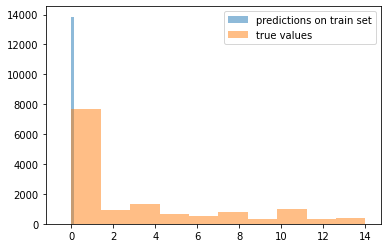

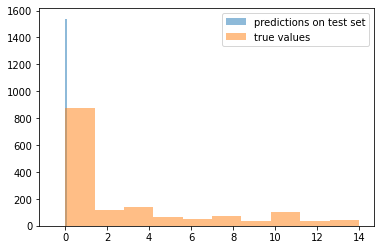

In [53]:
plt.hist(predictions_train,label='predictions on train set', alpha=0.5)
plt.hist(y_train,label='true values', alpha=0.5)
plt.legend()
plt.show()

plt.hist(predictions_test,label='predictions on test set', alpha=0.5)
plt.hist(y_test,label='true values', alpha=0.5)
plt.legend()
plt.show()